In [1]:
import random
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.problem_loaders.vrp_loader import VRPLoader
from src.algorithms.ga_vrp import GeneticAltorithmVRP
from src.algorithms.ant_system import AntSystem
from src.algorithms.ant_vrp import AntVRP
from src.plotting import plot_solution

# VRP with GA

Generation: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


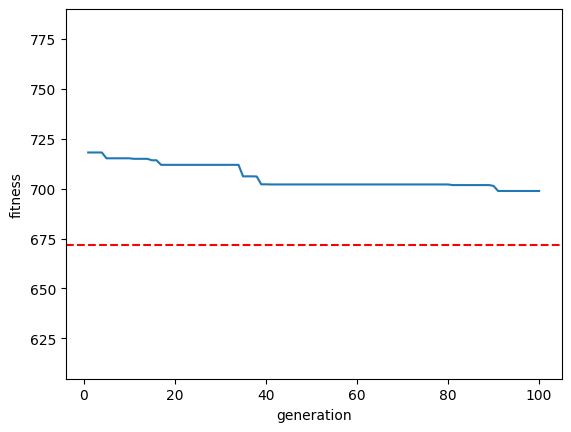

In [2]:
PROBLEM_INSTANCE_NAME = 'B-n31-k5'

tsp_loader = VRPLoader(PROBLEM_INSTANCE_NAME)
coordinates, problem_instance, demand, capacity, best_solution, best_solution_cost = tsp_loader.load_problem_instance()
ga = GeneticAltorithmVRP(problem_instance, coordinates, demand, capacity)
ga.run()
stats_df = ga.fitness_df()
chart = sns.lineplot(data=stats_df, x='generation', y='fitness')
plt.ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(best_solution_cost, color='red', linestyle='--')
plt.show()

d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:53: RuntimeWarning: invalid value encountered in divide
  unit_delta_x = delta_x / delta_length
d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:54: RuntimeWarning: invalid value encountered in divide
  unit_delta_y = delta_y / delta_length


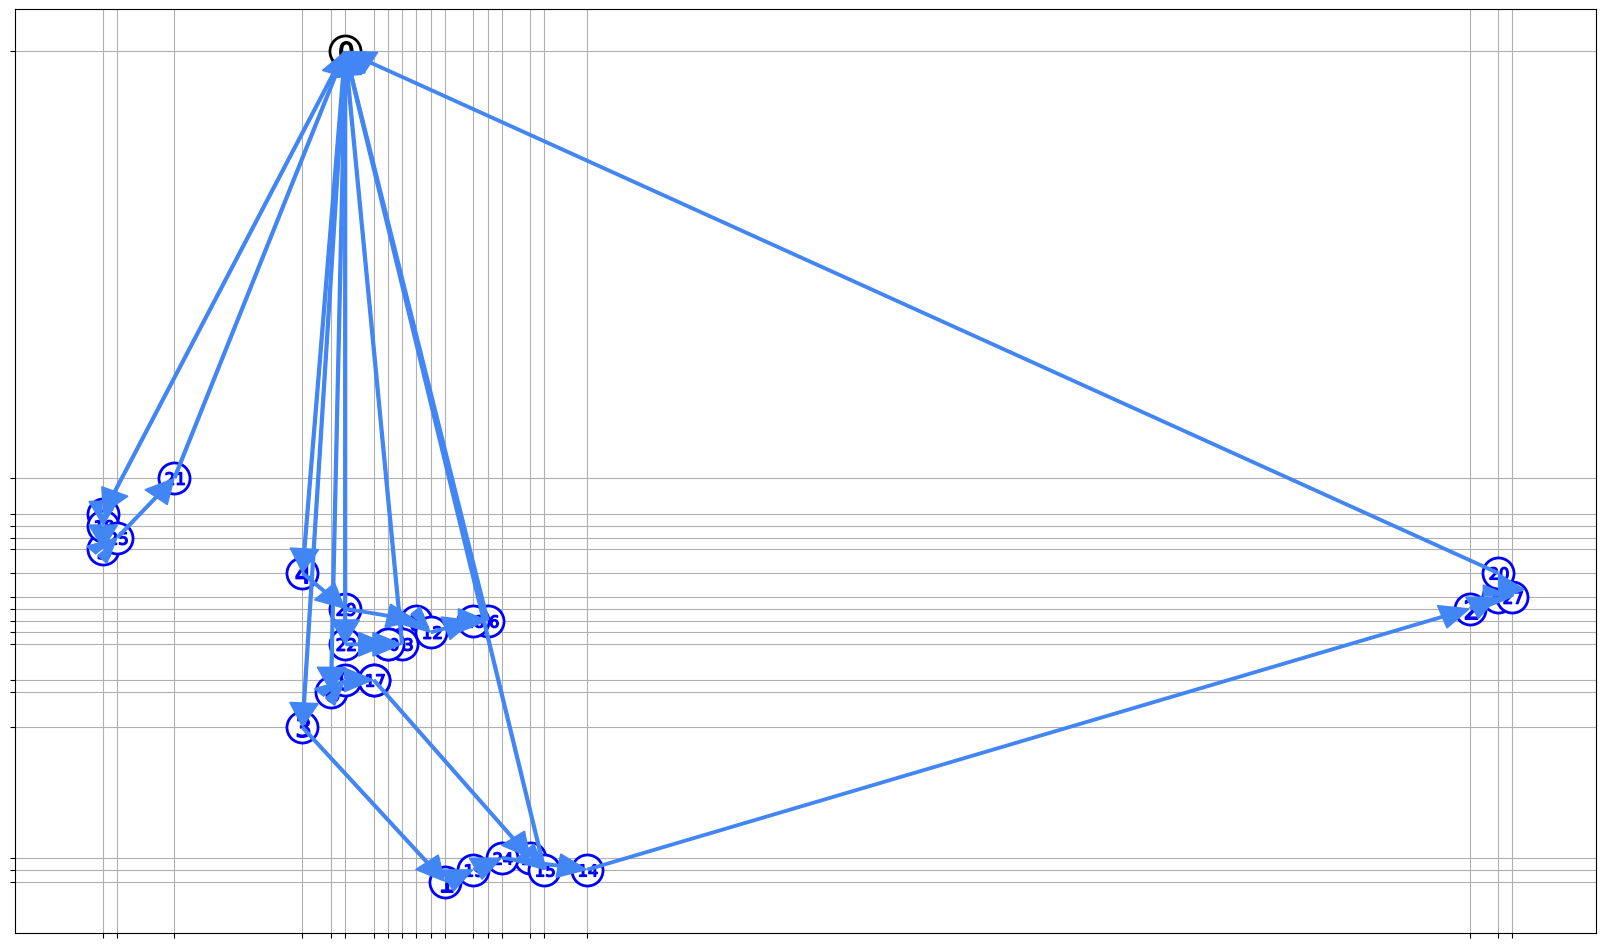

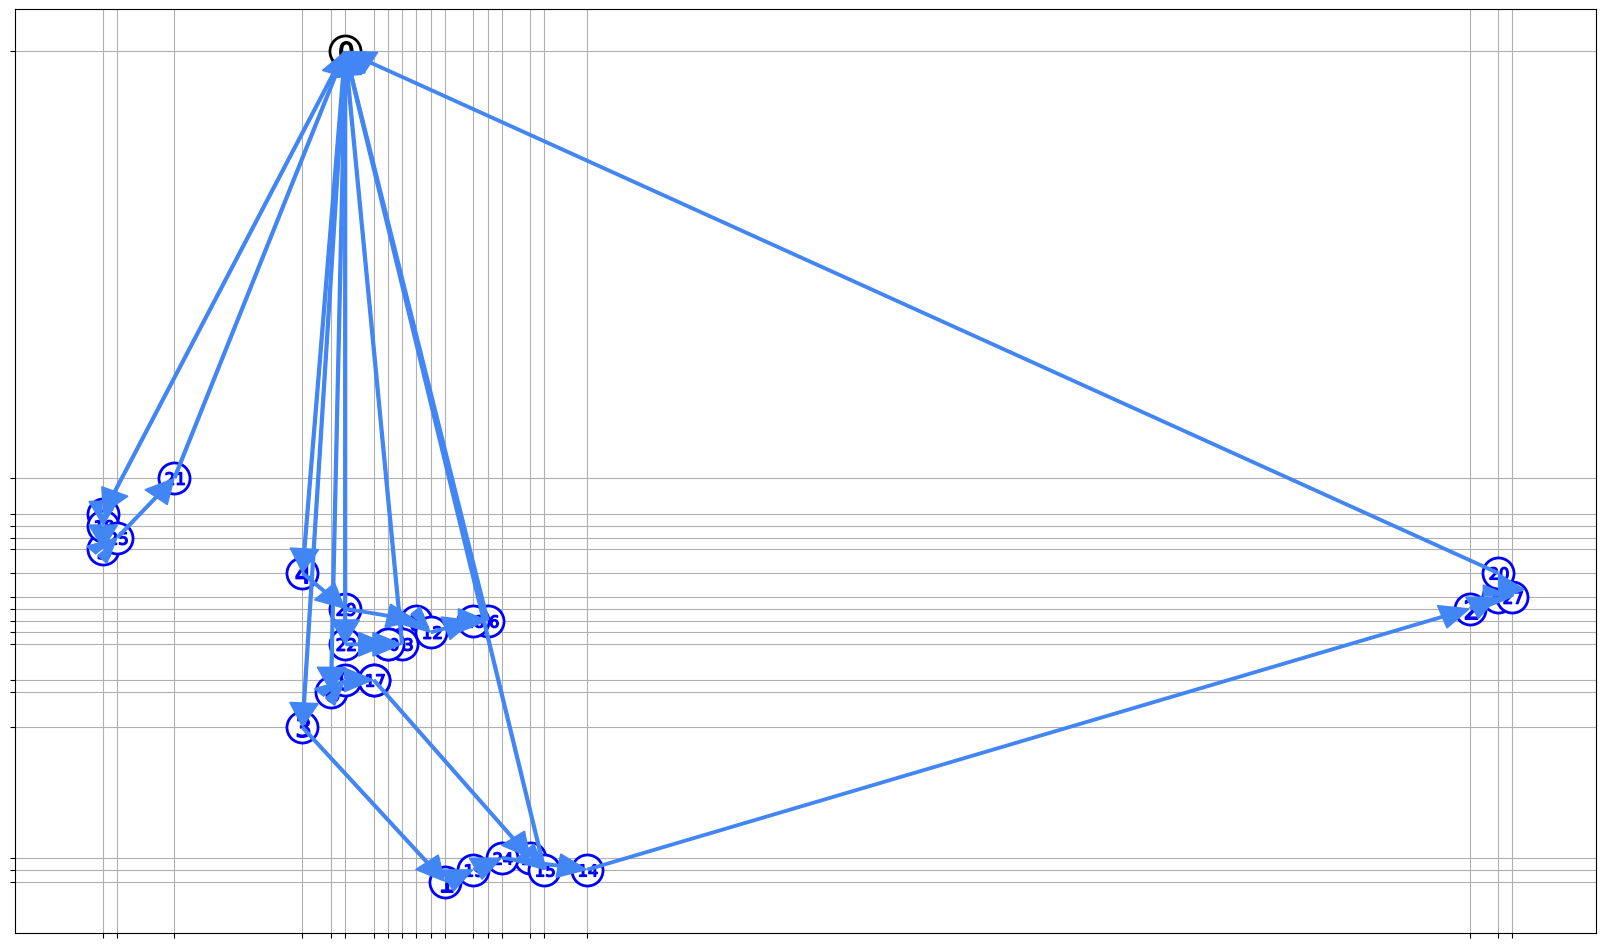

In [4]:
best_path = ga._get_paths(ga.best_solution.chromosome)[0]
single_path = list(itertools.chain.from_iterable(best_path)) + [0]
plot_solution(coordinates, single_path)

# VRP with Ant System

Time Point: 100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


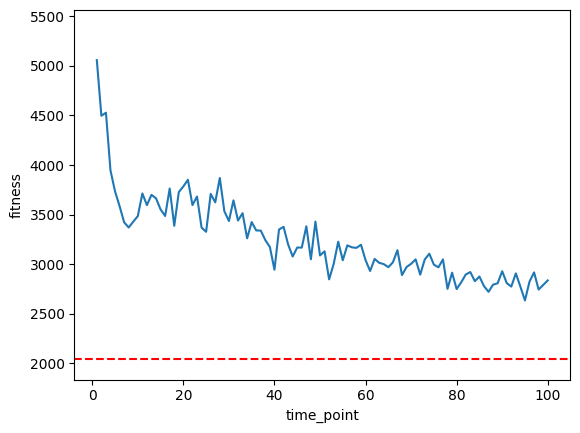

In [2]:
PROBLEM_INSTANCE_NAME = 'tai100a'

tsp_loader = VRPLoader(PROBLEM_INSTANCE_NAME)
coordinates, problem_instance, demand, capacity, best_solution, best_solution_cost = tsp_loader.load_problem_instance()
ant_system = AntSystem(AntVRP, problem_instance, demand=demand, capacity=capacity, debug_mode=False)
ant_system.run()
stats_df = ant_system.fitness_df()

chart = sns.lineplot(data=stats_df, x='time_point', y='fitness')
plt.ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(best_solution_cost, color='red', linestyle='--')
plt.show()

In [ ]:
plot_solution(coordinates, ant_system.best_path)